# Model Measurement

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Date & Time
from datetime import timedelta
from datetime import datetime, timedelta, date

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Models
from collections import namedtuple
from statsmodels.stats import anova
from statsmodels.formula.api import ols
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, wilcoxon, kruskal, friedmanchisquare, fisher_exact, chi2_contingency

In [16]:
# Static values for the script
DATE_START = datetime(2020,12,1)
DATA_SIZE = 260
DATE_FIELD = 'Date'
TARGET_FIELD = 'Sales'
TEST_FIELD = 'Test'

# Generate the simulated temperature data
np.random.seed(42)
_base_temp = np.random.lognormal(mean=2.0, sigma=0.42, size=DATA_SIZE)
_seasonal = [np.polyval([-5,0,-1], x) for x in np.linspace(start=0, stop=2, num=DATA_SIZE)]
temperature = np.linspace(start=45.0, stop=90.0, num=DATA_SIZE) + _base_temp + _seasonal
date_ranges = np.arange(DATE_START, 
                        DATE_START + timedelta(days=DATA_SIZE), 
                        timedelta(days=1)).astype(date)

##### Statistical Test Wrappers

In [17]:
def calculate_basic_stats(series):
    StatsData = namedtuple('StatsData', 'name mean median stddev variance sum')
    return StatsData(series.name,
                     np.mean(series.data),
                     np.median(series.data),
                     np.std(series.data),
                     np.var(series.data),
                     np.sum(series.data)
                    )

def series_comparison_continuous(a, b):
    BatteryData = namedtuple('BatteryData', 'left right anova mann_whitney_u wilcoxon ttest')
    TestData = namedtuple('TestData', 'statistic pvalue')
    anova_test = f_oneway(a.data, b.data)
    mann_whitney = mannwhitneyu(a.data, b.data)
    wilcoxon_rank = wilcoxon(a.data, b.data)
    t_test = ttest_ind(a.data, b.data, equal_var=False)
    return BatteryData(a.name, 
                       b.name, 
                       TestData(anova_test.statistic, anova_test.pvalue),
                       TestData(mann_whitney.statistic, mann_whitney.pvalue),
                       TestData(wilcoxon_rank.statistic, wilcoxon_rank.pvalue),
                       TestData(t_test.statistic, t_test.pvalue)
                      )

def calculate_basic_stats_df(series):
    StatsData = namedtuple('StatsData', 'name mean median stddev variance sum')
    return StatsData(series.name,
                     np.mean(series),
                     np.median(series),
                     np.std(series),
                     np.var(series),
                     np.sum(series)
                    )

def series_comparison_continuous_df(a, b):
    BatteryData = namedtuple('BatteryData', 'left right anova mann_whitney_u wilcoxon ttest')
    TestData = namedtuple('TestData', 'statistic pvalue')
    anova_test = f_oneway(a, b)
    mann_whitney = mannwhitneyu(a, b)
    wilcoxon_rank = wilcoxon(a, b)
    t_test = ttest_ind(a, b, equal_var=False)
    return BatteryData(a.name, 
                       b.name, 
                       TestData(anova_test.statistic, anova_test.pvalue),
                       TestData(mann_whitney.statistic, mann_whitney.pvalue),
                       TestData(wilcoxon_rank.statistic, wilcoxon_rank.pvalue),
                       TestData(t_test.statistic, t_test.pvalue)
                      )

def multi_series_equivalency(series):
    series_data = [x.data for x in series]
    StatResults = namedtuple('StatResults', 'kruskal friedman')
    kruskal_test = kruskal(*series_data)
    friedman_test = friedmanchisquare(*series_data)
    return StatResults(kruskal_test, friedman_test)

##### Data Manipulation Functions

In [18]:
def prevent_negatives(series):
    return [0.0 if x < 0.0 else x for x in series]

def generate_series(base_start, base_end, variance_mu, variance_sigma, group_name, data_size=DATA_SIZE):
    Test_Series = namedtuple('Test_Series', 'name data start stop mu sigma')
    noise_factor = np.random.normal(variance_mu, variance_sigma, data_size)
    generated = np.linspace(start=base_start, stop=base_end, num=data_size) + noise_factor
    return Test_Series(group_name, prevent_negatives(generated), base_start, base_end, variance_mu, variance_sigma)

def generate_data(config):
    series_gen = []
    for k, v in config.items():
        for pk, pv in v.items():
            generated = generate_series(pv['start'], pv['stop'], pv['mu'], pv['sigma'], "{}_{}".format(pk, k))
            series_gen.append(generated)
    return series_gen

def generate_df(series_collection, dates):
    series_df = pd.DataFrame.from_records([x.data for x in series_collection]).T
    series_df.columns = [x.name for x in series_collection]
    series_df[DATE_FIELD] = dates
    return series_df

def generate_melted_df(series_collection, dates, date_filtering=DATA_SIZE):
    series_df = generate_df(series_collection, dates)
    melted = pd.melt(series_df.reset_index(), id_vars='Date', value_vars=[x.name for x in series_collection])
    melted.columns = [DATE_FIELD, 'Test', 'Sales']
    return melted[melted[DATE_FIELD] > max(melted[DATE_FIELD]) - timedelta(days=date_filtering)]

def generate_augmented_df(series_data):
    our_data_df = generate_df(series_data, date_ranges)
    for i in ['High', 'Medium', 'Low']:
        our_data_df['{}_Value_Sales'.format(i)] = (
            our_data_df['Control_{}_Value'.format(i)] + our_data_df['Test_{}_Value'.format(i)])
    our_data_df['Control_Sales'] = (
        our_data_df['Control_High_Value'] + 
        our_data_df['Control_Medium_Value'] + 
        our_data_df['Control_Low_Value'])
    our_data_df['Test_Sales'] = (
        our_data_df['Test_High_Value'] + 
        our_data_df['Test_Medium_Value'] + 
        our_data_df['Test_Low_Value'])
    our_data_df['Total_Sales'] = our_data_df['Control_Sales'] + our_data_df['Test_Sales']
    return our_data_df

def filter_augmented_start(data, days_forward=30):
    return data[data[DATE_FIELD] < min(data[DATE_FIELD]) + timedelta(days=days_forward)]

def filter_augmented_latest(data, days_back=30):
    return data[data[DATE_FIELD] > max(data[DATE_FIELD]) - timedelta(days=days_back)]

def extract_data(result_data, index, data_type):
    return pd.Series([x[index] for x in result_data], dtype=np.dtype(data_type))

def convert_tukey_to_df(tukey):
    STRUCTURES = [(0, 'str'), (1, 'str'), (2, 'float'), (3, 'float'), (4, 'float'), (5, 'float'), (6, 'bool')]
    fields = tukey.data[0]
    extracts = [extract_data(tukey.data[1:], x[0], x[1]) for x in STRUCTURES]
    result_df = pd.concat(extracts, axis=1)
    result_df.columns = fields
    return result_df.sort_values(['p-adj', 'meandiff'], ascending=[True, False])

def run_anova(data, value_name, group_name):
    ols_model = ols('{} ~ C({})'.format(value_name, group_name), data=data).fit()
    return anova.anova_lm(ols_model, typ=2)

def run_tukey(value, group, alpha=0.05):
    paired_test = pairwise_tukeyhsd(value, group, alpha)
    return convert_tukey_to_df(paired_test._results_table)

##### Setting Plotting Functions

In [19]:
def plot_corr(x, y, x_name, y_name, size=(10,10)):
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        ax.scatter(x, y)
        ax.set_title("Correlation of {} and {}".format(x_name, y_name))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.plot(np.unique(x), 
                np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
                color='darkred', 
                label='linear fit')
        ax.plot(np.unique(x), 
                np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), 
                color='green', 
                label='2nd degree polynomial fit', 
                linestyle='--')
        ax.text(min(x), min(y),"Correlation coefficient: {}".format(np.corrcoef(x,y)[0][1]))
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig("{}_{}_correlation.svg".format(x_name, y_name), format='svg')

def plot_comparison_series_df(x, y1, y2, name, size=(10,10)):
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        ax.plot(x, y1, color='darkred', label=y1.name)
        ax.plot(x, y2, color='green', label=y2.name)
        ax.set_title("Comparison of Sales between tests {} and {}".format(y1.name, y2.name))
        ax.set_xlabel(DATE_FIELD)
        ax.set_ylabel(TARGET_FIELD)
        comparison = series_comparison_continuous_df(y1, y2)
        y1_stats = calculate_basic_stats_df(y1)
        y2_stats = calculate_basic_stats_df(y2)
        bbox_stats = "\n".join((
            "Series {}:".format(y1.name),
            "   Mean: {:.2f}".format(y1_stats.mean),
            "   Median: {:.2f}".format(y1_stats.median),
            "   Stddev: {:.2f}".format(y1_stats.stddev),
            "   Variance: {:.2f}".format(y1_stats.variance),
            "   Sum: {:.2f}".format(y1_stats.sum),
            "Series {}:".format(y2.name),
            "   Mean: {:.2f}".format(y2_stats.mean),
            "   Median: {:.2f}".format(y2_stats.median),
            "   Stddev: {:.2f}".format(y2_stats.stddev),
            "   Variance: {:.2f}".format(y2_stats.variance),
            "   Sum: {:.2f}".format(y2_stats.sum)
        ))
        bbox_text = "Anova pvalue: {}\nT-test pvalue: {}\nMannWhitneyU pvalue: {}\nWilcoxon pvalue: {}".format(
            comparison.anova.pvalue,
            comparison.ttest.pvalue,
            comparison.mann_whitney_u.pvalue,
            comparison.wilcoxon.pvalue
        )
        bbox_props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)
        ax.text(0.05, 0.95, bbox_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=bbox_props)
        ax.text(0.05, 0.8, bbox_stats, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)
        ax.legend(loc='lower right')
        plt.tight_layout()    
        plt.savefig('time_series_{}.svg'.format(name), format='svg')
        
def plot_anova(melted_data, plot_name, figsize=(16, 16)):
    anova_report = run_anova(melted_data, 'Sales', 'Test')
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=figsize)
        ax0 = fig.add_subplot(111)
        ax0 = sns.boxplot(x='Test', y='Sales', data=melted_data, color='lightsteelblue')
        ax0 = sns.stripplot(x='Test', y='Sales', data=melted_data, color='steelblue', alpha=0.4, jitter=0.2)
        ax1 = fig.add_subplot(211)
        ax1.set_title("Anova Analysis of tests", y=1.25, fontsize=16)
        tbl = ax1.table(cellText=anova_report.values, 
                        colLabels=anova_report.columns, 
                        rowLabels=anova_report.index, 
                        loc='top', 
                        cellLoc='center', 
                        rowLoc='center',
                        bbox=[0.075,1.0,0.875,0.2]
                       )
        tbl.auto_set_column_width(col=list(range(len(anova_report.columns))))
        ax1.axis('tight')
        ax1.set_axis_off()
        ax0.tick_params(axis='x', rotation=45)
        plt.savefig("anova_{}.svg".format(plot_name), format='svg')

def plot_tukey(melted_data, name, alpha=0.05, figsize=(14,14)):
    tukey_data = run_tukey(melted_data[TARGET_FIELD], melted_data[TEST_FIELD], alpha)
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=figsize)
        ax_plot = fig.add_subplot(111)
        ax_plot = sns.boxplot(x=TEST_FIELD, y=TARGET_FIELD, data=melted_data, color='lightsteelblue')
        ax_plot = sns.stripplot(x=TEST_FIELD, y=TARGET_FIELD, 
                                data=melted_data, color='steelblue', alpha=0.4, jitter=0.2)
        ax_table = fig.add_subplot(211)
        ax_table.set_title("TukeyHSD Analysis of tests", y=1.5, fontsize=16)
        tbl = ax_table.table(cellText = tukey_data.values,
                             colLabels = tukey_data.columns,
                             rowLabels = tukey_data.index,
                             loc='top',
                             cellLoc='center',
                             rowLoc='center',
                             bbox=[0.075, 1.0, 0.875, 0.5]
                            )
        tbl.auto_set_column_width(col=list(range(len(tukey_data.columns))))
        ax_table.axis('tight')
        ax_table.set_axis_off()
        plt.tight_layout()
        plt.savefig('tukey_{}.svg'.format(name), format='svg')

def plot_equivalency_series(x, y, plot_name, size=(10,10)):
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111)
        [ax.plot(x, z.data, label=z.name) for z in y]
        ax.set_title("Comparison of Sales")
        ax.set_xlabel(DATE_FIELD)
        ax.set_ylabel(TARGET_FIELD)
        comparison = multi_series_equivalency(y)
        bbox_text = "Kruskal pvalue: {}\nFriedman Chisq pvalue: {}".format(
            comparison.kruskal.pvalue,
            comparison.friedman.pvalue
        )
        bbox_props = dict(boxstyle='round', facecolor='ivory', alpha=0.8)
        ax.text(0.05, 0.95, bbox_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=bbox_props)
        ax.legend(loc='lower right')
        plt.tight_layout()  
        plt.savefig('equivalency_test_{}.svg'.format(plot_name), format='svg')
        
def plot_single_series(data, y_field, y_name, y_label, title, image_name, figsize=(10,8)):
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(data['Date'],data[y_field]*0.8, label=y_name)
        ax.set_xlabel("Date")
        ax.set_ylabel(y_label)
        ax.set_title(title, fontsize=14)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig('{}.svg'.format(image_name), format='svg')

##### Configuration for Data Generators

In [20]:
config = {
    'High_Value': {
        'Control': {
            'start': 5000,
            'stop': 145000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 5000,
            'stop': 160000,
            'mu': 8000,
            'sigma': 4500
        }
    },
    'Medium_Value': {
        'Control': {
            'start': 6000,
            'stop': 105000,
            'mu': 2000,
            'sigma': 4000
        },
        'Test': {
            'start': 6000,
            'stop': 105000,
            'mu': 3000,
            'sigma': 6000
        }
    },
    'Low_Value': {
        'Control': {
            'start': 10000,
            'stop': 50000,
            'mu': 1000,
            'sigma': 5000
        },
        'Test': {
            'start': 10000,
            'stop': 60000,
            'mu': 1750,
            'sigma': 8000
        }
    },
}

config_baseline = {
    'High_Value': {
        'Baseline': {
            'start': 8000,
            'stop': 244000,
            'mu': 11200,
            'sigma': 7200
        }
    },
    'Medium_Value': {
        'Baseline': {
            'start': 9600,
            'stop': 168000,
            'mu': 4000,
            'sigma': 8000
        }
    },
    'Low_Value': {
        'Baseline': {
            'start': 16000,
            'stop': 88000,
            'mu': 2200,
            'sigma': 10400
        }
    }
}

config_stationary = {
    'High_Value': {
        'Control': {
            'start': 150000,
            'stop': 151000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 185000,
            'stop': 186000,
            'mu': 8000,
            'sigma': 4500
        }
    },
    'Medium_Value': {
        'Control': {
            'start': 100000,
            'stop': 100500,
            'mu': 2000,
            'sigma': 4000
        },
        'Test': {
            'start': 100000,
            'stop': 100500,
            'mu': 2000,
            'sigma': 8000
        }
    },
    'Low_Value': {
        'Control': {
            'start': 50000,
            'stop': 50500,
            'mu': 1000,
            'sigma': 5000
        },
        'Test': {
            'start': 52000,
            'stop': 52500,
            'mu': 1750,
            'sigma': 8000
        }
    },
}

config_stationary_anova = {
    'High_Value': {
        'Control': {
            'start': 150000,
            'stop': 151000,
            'mu': 6000,
            'sigma': 4500
        },
        'Test': {
            'start': 185000,
            'stop': 186000,
            'mu': 8000,
            'sigma': 4500
        }
    }
}

#### Total Sales over Time

In [21]:
baseline_data = generate_data(config)
augmented = generate_augmented_df(baseline_data)

In [22]:
plot_single_series(augmented, 'Total_Sales', 'Ice Cream Sales', 'Sales', 'Daily Sales of our Ice Cream', 
                   'overall_sales')

#### RFM Histograms

In [45]:
recency = np.random.pareto(100, 500) * 1000
monetary = np.random.normal(10000, 500, 500) + (np.random.pareto(1000, 500) * 200000 )
frequency = np.random.pareto(100, 500) * 500

def get_ntiles(series, name):
    NtilePayload = namedtuple('NTiles', 'series p20 p40 p60 p80')
    return NtilePayload(
        name,
        np.percentile(series, 20),
        np.percentile(series, 40),
        np.percentile(series, 60),
        np.percentile(series, 80)
    )

def get_next_range(pre, current):
    return pre + current

def plot_distribution_rfm(series, series_name, figsize=(10,6)):
    with plt.style.context(style='seaborn-v0_8'):
        fig = plt.figure(figsize=figsize)
        f_ntile = get_ntiles(series, series_name)
        ax = plt.hist(series, facecolor='0.4', bins=80)
        xmin, xmax, ymin, ymax = plt.axis()
        colors = ['dodgerblue', 'forestgreen', 'yellow', 'darkorange', 'red']
        if series_name == 'recency':
            colors.reverse()
        plt.axvspan(max(0, xmin), f_ntile.p20, ymin, ymax, facecolor=colors[0], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p20, f_ntile.p40, ymin, ymax, facecolor=colors[1], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p40, f_ntile.p60, ymin, ymax, facecolor=colors[2], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p60, f_ntile.p80, ymin, ymax, facecolor=colors[3], alpha=0.5, zorder=-100)
        plt.axvspan(f_ntile.p80, xmax, ymin, ymax, facecolor=colors[4], alpha=0.5, zorder=-100)
        plt.title("Distribution of {}".format(series_name))
        if series_name == 'recency':
            plt.xlabel("Days since last purchase")
        elif series_name == 'frequency':
            plt.xlabel("Frequency of purchases")
        else:
            plt.xlabel("Total Lifetime Spend")
        plt.ylabel("Customer count")
        plt.tight_layout()
        plt.savefig('rfm_{}.svg'.format(series_name), format='svg')

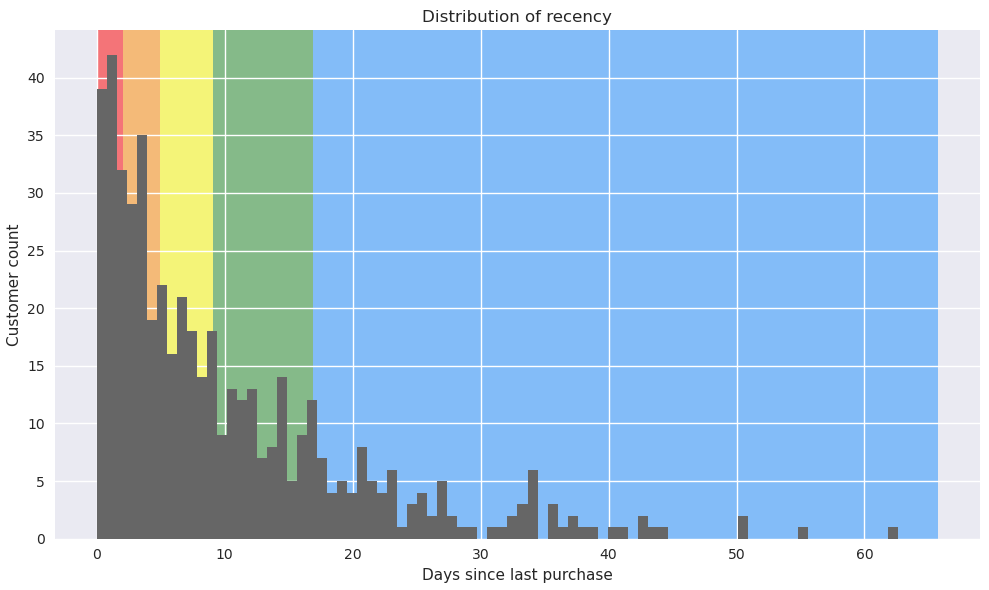

In [46]:
plot_distribution_rfm(recency, 'recency')
plt.show()

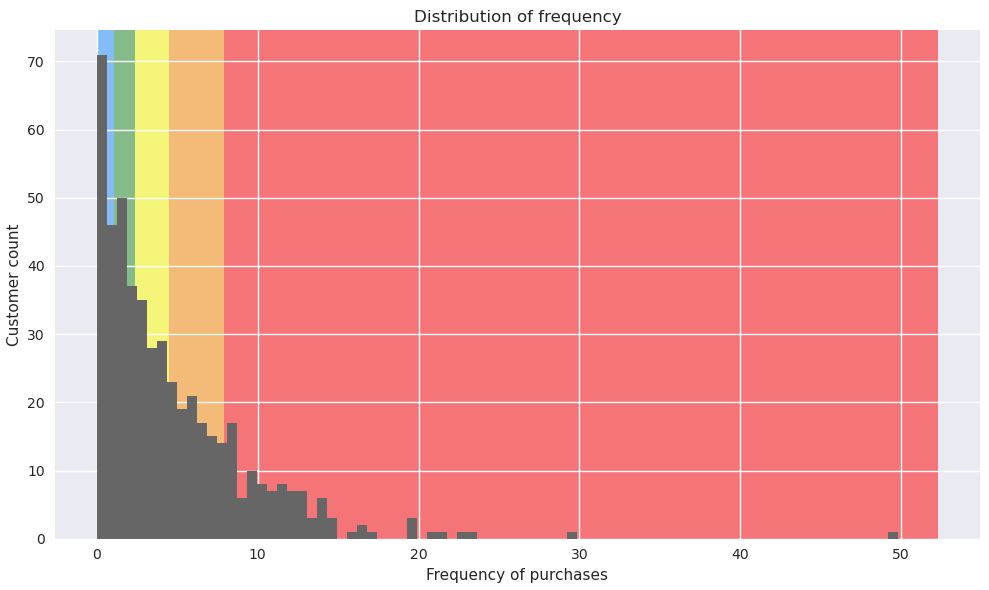

In [47]:
plot_distribution_rfm(frequency, 'frequency')
plt.show()

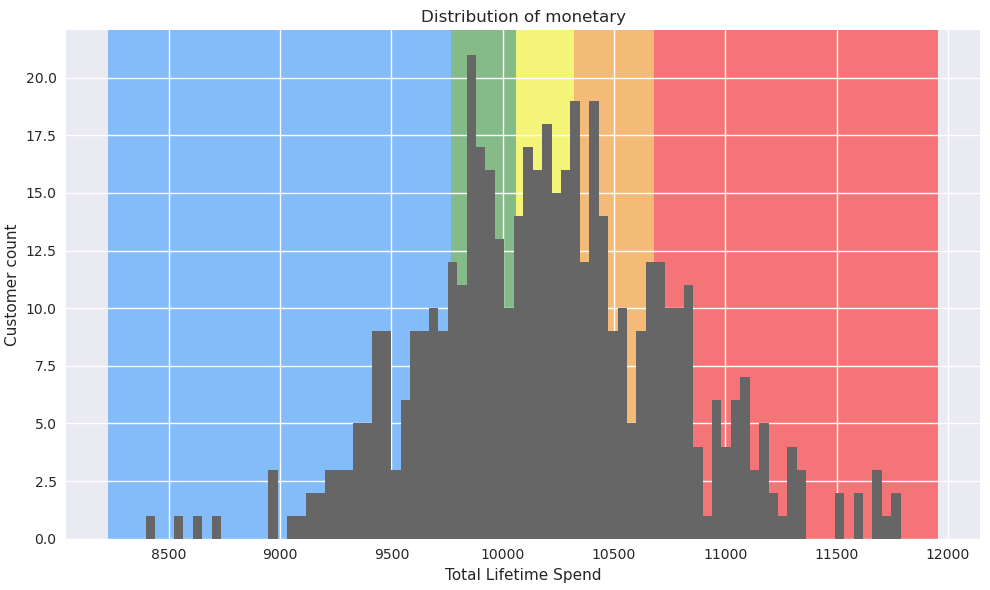

In [48]:
plot_distribution_rfm(monetary, 'monetary')
plt.show()

#### Equivalency Testing (Multivariate) with ANOVA and Kruskal

In [49]:
anova_data = generate_data(config_baseline)

plot_equivalency_series(date_ranges, anova_data, 'baseline', (8,8))

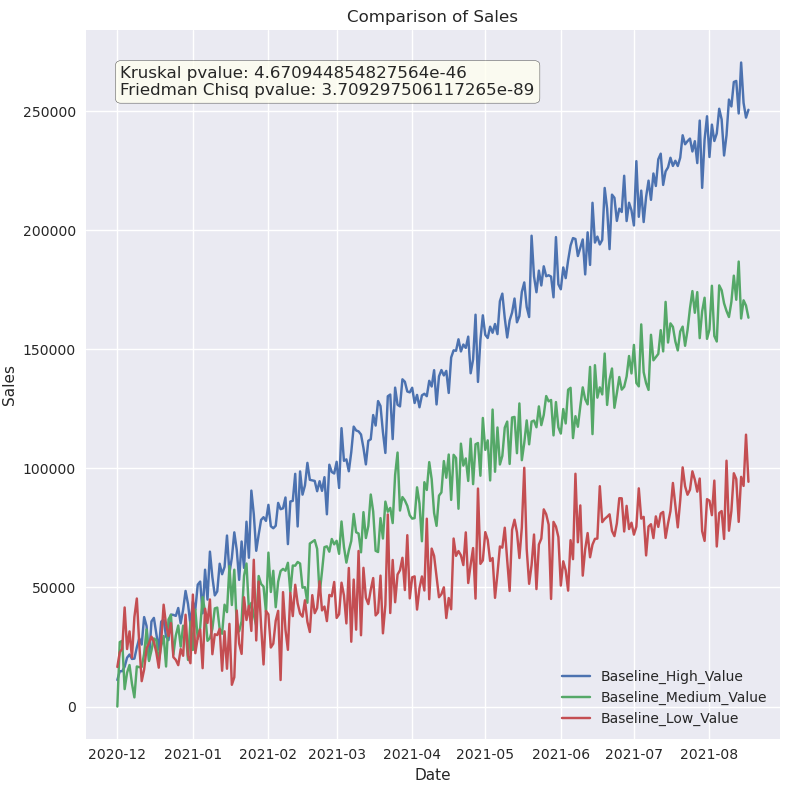

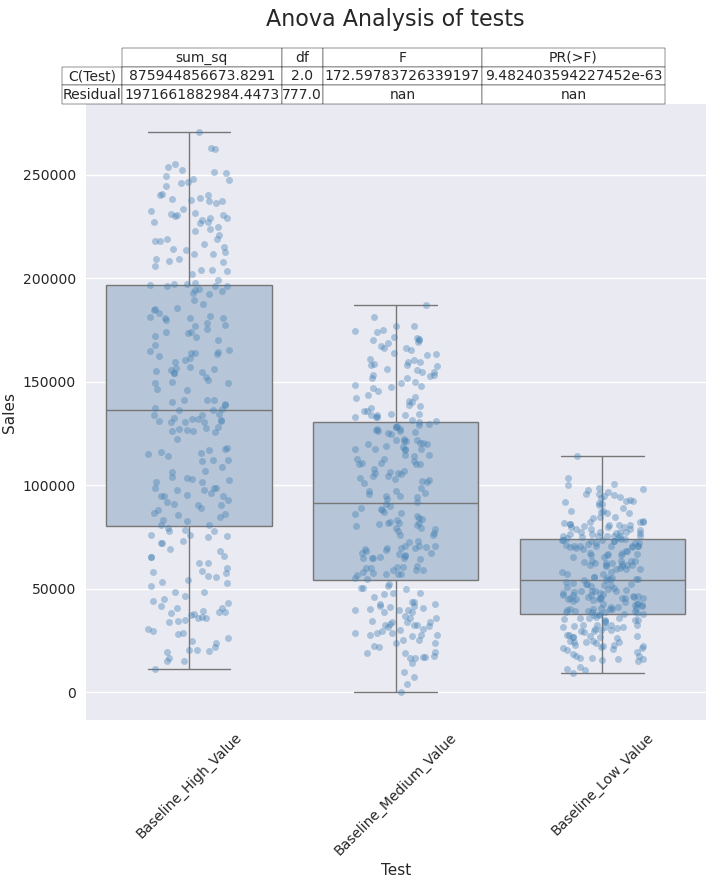

In [50]:
plot_anova(generate_melted_df(anova_data, date_ranges, 300), 'baseline', (8,8))
plt.show()

#### Correlation & Causality

In [51]:
augmented['temperature'] = temperature

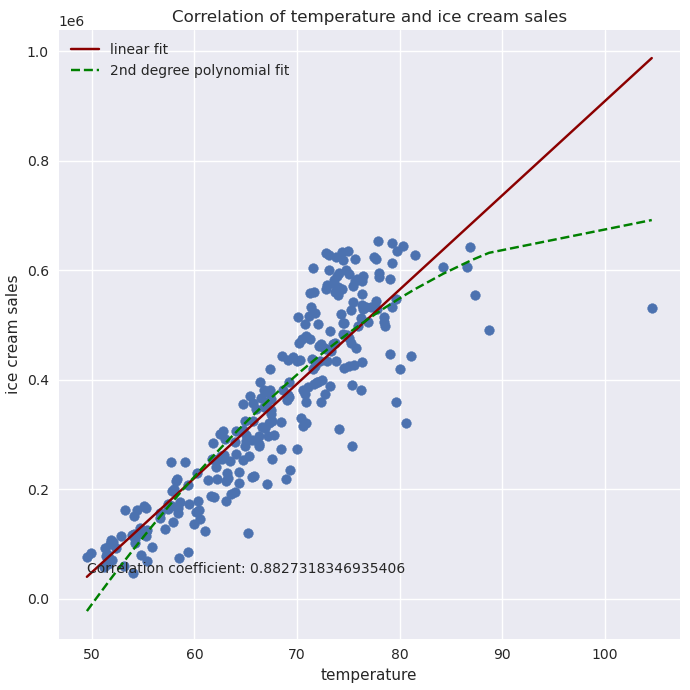

In [52]:
plot_corr(augmented['temperature'], augmented['Total_Sales'], 'temperature', 'ice cream sales', (7,7))
plt.show()

In [53]:
_base_clouds = np.random.normal(0.0, 0.05, DATA_SIZE)
cloud_cover = np.linspace(start=0.0, stop=0.9, num=DATA_SIZE)[::-1] + _base_clouds

augmented['cloud_cover'] = cloud_cover
plot_corr(augmented['cloud_cover'], augmented['Total_Sales'], 'cloud cover', 'ice cream sales', (7,7))

#### Listing Up

In [54]:
effect_size = tt_ind_solve_power(effect_size=0.1, nobs1=None, alpha=0.2, power=0.8, ratio=1, alternative='two-sided')
effect_size

900.975488079142

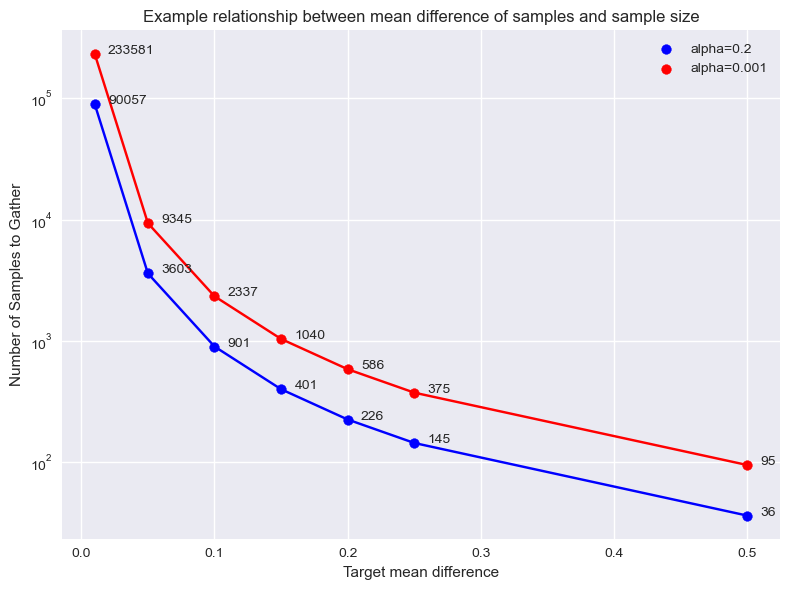

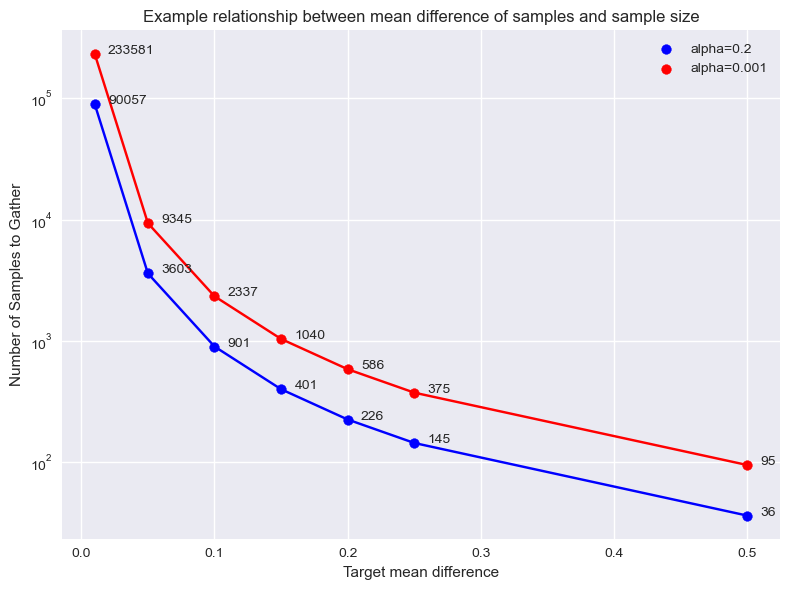

In [59]:
x_effects = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5]
sample_sizes = [tt_ind_solve_power(x, None, 0.2, 0.8, 1, 'two-sided') for x in x_effects]
sample_sizes_low_alpha = [tt_ind_solve_power(x, None, 0.01, 0.8, 1, 'two-sided') for x in x_effects]

with plt.style.context(style='seaborn-v0_8'):
    fig = plt.figure(figsize=(8,6))
    ax = plt.plot(x_effects, sample_sizes, color='blue')
    plt.scatter(x_effects, sample_sizes, label='alpha=0.2', color='blue')
    ax1 = plt.plot(x_effects, sample_sizes_low_alpha, color='red')
    plt.scatter(x_effects, sample_sizes_low_alpha, label = 'alpha=0.001', color='red')
    plt.yscale('log')
    plt.legend(loc='best')
    for i, v in enumerate(sample_sizes):
        plt.annotate(np.round(v,0).astype(int), (x_effects[i] + 0.01, v))
    for i, v in enumerate(sample_sizes_low_alpha):
        plt.annotate(np.round(v,0).astype(int), (x_effects[i] + 0.01, v))
    plt.ylabel('Number of Samples to Gather')
    plt.xlabel('Target mean difference')
    plt.title("Example relationship between mean difference of samples and sample size")
    plt.tight_layout()
    plt.savefig('sample_sizes.svg', format='svg')
    plt.show()

#### Plotting Element

In [60]:
filter_aug_start = filter_augmented_start(augmented, 7)

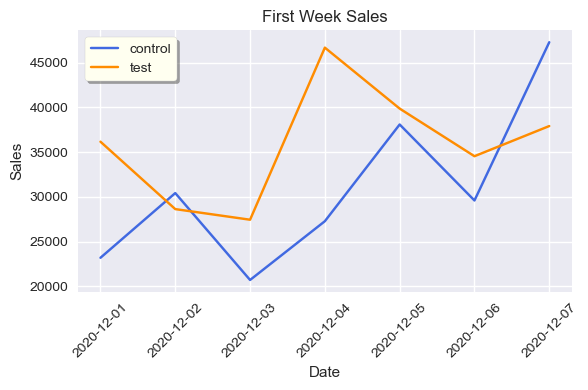

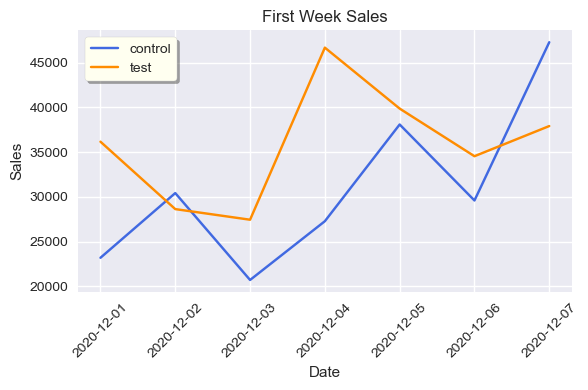

In [62]:
with plt.style.context(style='seaborn-v0_8'):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.plot(filter_aug_start['Date'], filter_aug_start['Control_Sales'], color='royalblue', label='control')
    ax.plot(filter_aug_start['Date'], filter_aug_start['Test_Sales'], color='darkorange', label='test')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.xticks(rotation=45)
    ax.set_title("First Week Sales")
    legend = ax.legend(loc='best', shadow=True, frameon=True)
    legend.get_frame().set_facecolor('ivory')
    plt.tight_layout()
    plt.savefig('first_week_sales.svg', format='svg')
    plt.show()